In [1]:
import lbcred, os, random, ccdproc
from lbcred import image, interactive, tools, reduce
from astropy.nddata import CCDData
import numpy as np


%matplotlib inline
%config InlineBackend.figure_format='retina'

# New imports
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy import log
from astropy.modeling import models, fitting


In [2]:
default_config = os.path.join(lbcred.project_dir, 'lbcreduce-config.yml')
initial_config = tools.initialize_config(default_config)
config, dir_overwritten = interactive.initialize_directories(initial_config)
image_info = image.get_image_info(config)
image.check_files(image_info, config)
image_info = image.separate_chips(image_info, config)

{'degree': 4, 'domain': None, 'window_lower': -1, 'window_upper': 1, 'n_models': None, 'model_set_axis': None, 'name': None, 'meta': None}
{'degree': 4, 'domain': None, 'window_upper': 1, 'n_models': None, 'model_set_axis': None, 'name': None, 'meta': None}
{'degree': 4, 'domain': None, 'n_models': None, 'model_set_axis': None, 'name': None, 'meta': None}
{'degree': 4, 'domain': None, 'n_models': None, 'model_set_axis': None, 'name': None, 'meta': None, 'window': [-1, 1]}


In [3]:
flats = image_info[np.where(image_info['imagetyp']=='flat')].copy()
bias = image_info[np.where(image_info['imagetyp']=='zero')].copy()
obj = image_info[np.where(image_info['imagetyp']=='object')].copy()
obj

filename,imagetyp,object,propid,filter,instrument
str31,str6,str9,str13,str8,str8
lbcr.20191221.034630-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcr.20191221.035330-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcr.20191221.040043-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcb.20191220.071505-chip2.fits,object,M81blob,OSU_LBCSBF,B-BESSEL,LBC_BLUE
lbcr.20191221.034512-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,R-BESSEL,LBC-RED
lbcb.20191221.031039-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE
lbcb.20191221.031734-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE
lbcb.20191221.030450-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE
lbcb.20191221.032428-chip2.fits,object,NGC628LSB,OSU_dwarfsimg,B-BESSEL,LBC_BLUE


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


<Figure size 432x288 with 0 Axes>

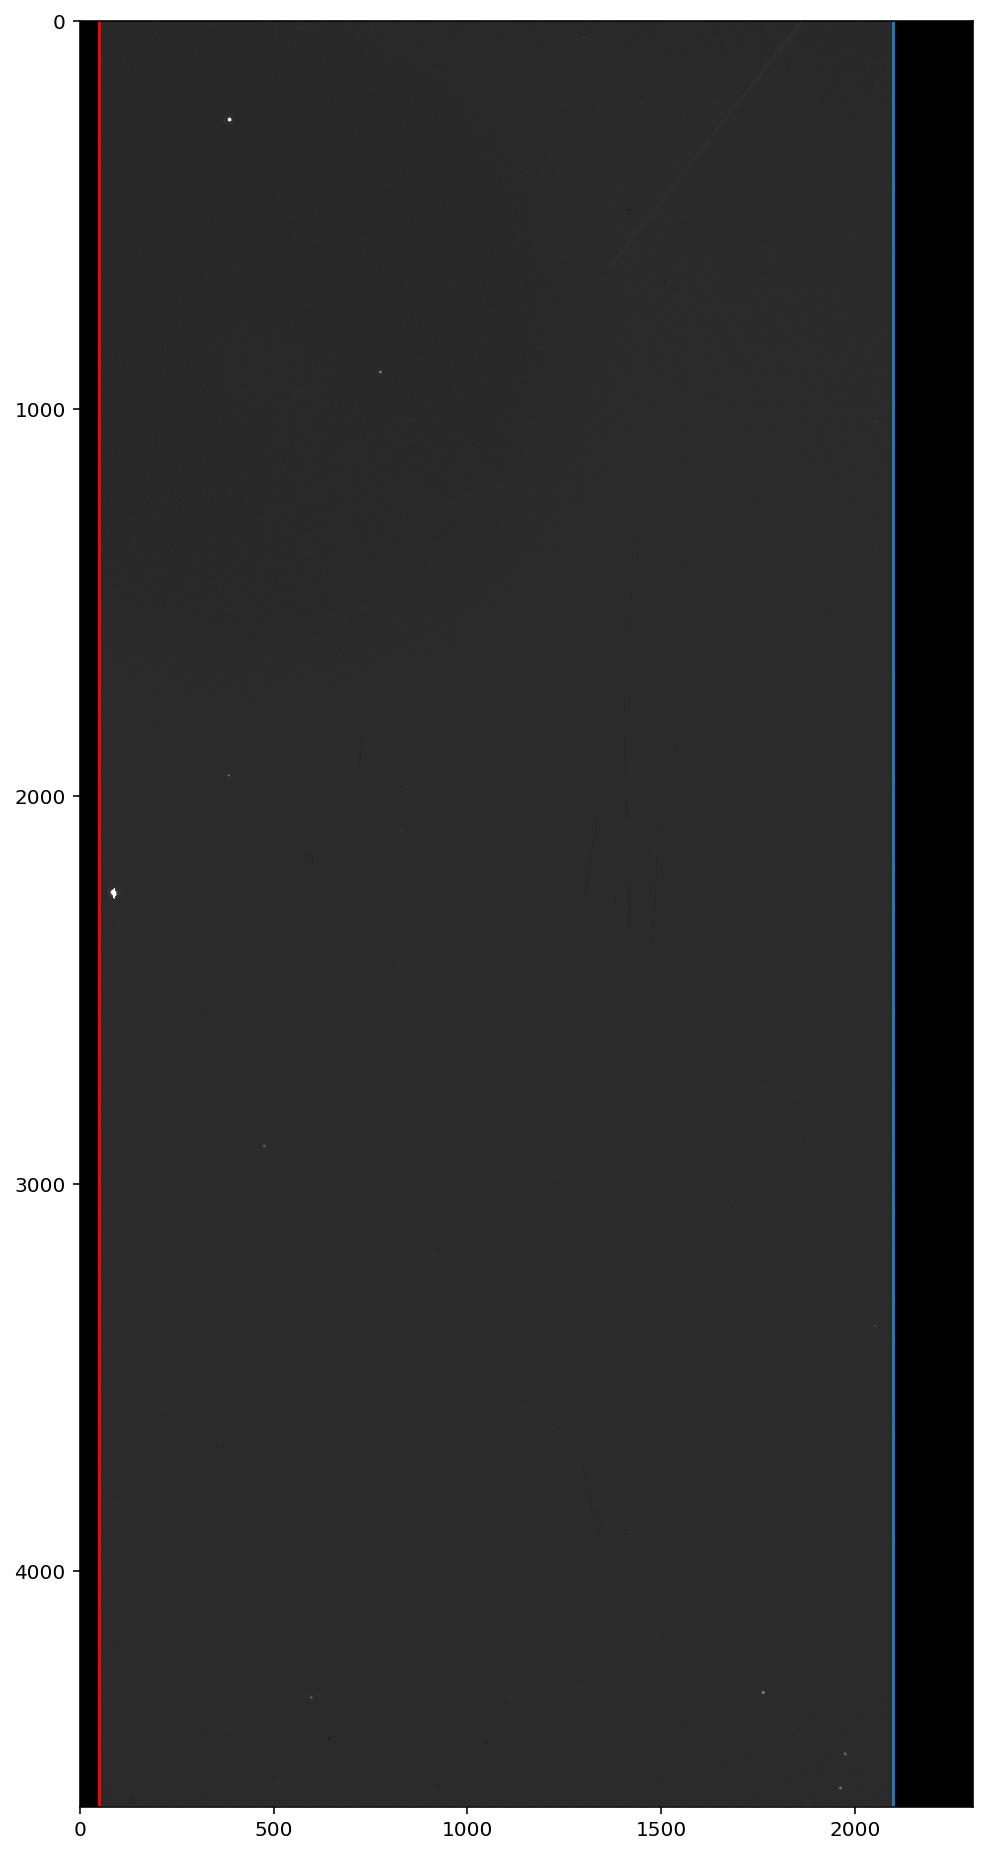

In [4]:
#tools.plot_overscan(image_info, config, 10)
# [2099:2304,1:4608]

def get_overscan(image_info, config, num_images = 1, axis = 0, flatten_func = 'median'):

    # Get images to plot
    plot_files = list(image_info['filename'])
    if num_images is not None:
        plot_files = random.sample(list(plot_files), num_images)
    plt.clf()
    
    for file in plot_files:
        data = CCDData.read(os.path.join(config['out_dir'], 'midproc', file), unit=config['data_units'], hdu=config['ext'])
        ymin, ymax, xmin, xmax = image.get_ccd_section(data.meta, config['overscan_region'])
        overscan = data.data[xmin:xmax,ymin:ymax].copy()
        


        fig = plt.figure(figsize=(8,20))
        plt.axvline(x=2098, ymin=0, ymax=4607)
        plt.axvline(x=49, ymin=0, ymax=4607,c='r')
        plt.imshow(data, cmap = 'gray')

get_overscan(flats,config)

In [244]:
#tools.plot_overscan(image_info, config, 10)
# [2099:2304,1:4608]
numRows12 = int(4608/12 - 1)
numRows6 = int(4608/6 - 1)

def plot_overscan(image_info, config, imagetyp, num_images = 0, flatten_func = None, modeltype = 'legendre', axis = 0):

    log.setLevel('ERROR')

    # Get images to plot
    plot_files = list(image_info['filename'])
    if num_images is not 0:
        plot_files = random.sample(list(plot_files), num_images)
    else: num_images = len(plot_files)
    plt.clf()
    
    median12 = np.ndarray((num_images,numRows12))
    mean12 = np.ndarray((num_images,numRows12))
    sigclipped_mean12 = np.ndarray((num_images,numRows12))
    median6 = np.ndarray((num_images,numRows6))
    mean6 = np.ndarray((num_images,numRows6))
    sigclipped_mean6 = np.ndarray((num_images,numRows6))

    idx1 = 0
    x = np.arange(len(median12[idx1]))
    fig = plt.figure(figsize=(20,12))
    
    for file in plot_files:
        data = CCDData.read(os.path.join(config['out_dir'], 'midproc', file), unit=config['data_units'], hdu=config['ext'])
        xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['overscan_region'])
        overscan = data.data[xmin:xmax,ymin:ymax].copy()

        idx12 = 0
        idx6 = 0
        saverow12 = []
        saverow6 = []
        count = 0
        for row in overscan:
            
            saverow12 = np.append(saverow12,row)
            saverow6 = np.append(saverow6,row)
            
            if count%12 is 0 and count is not 0:

                median12[idx1][idx12] = np.median(saverow12)
                mean12[idx1][idx12] = np.mean(saverow12)
                sigclipped_mean12[idx1][idx12] = np.mean(sigma_clip(saverow12))
                saverow12=[]
                idx12 += 1
                
            if count%6 is 0 and count is not 0:

                median6[idx1][idx6] = np.median(saverow6)
                mean6[idx1][idx6] = np.mean(saverow6)
                sigclipped_mean6[idx1][idx6] = np.mean(sigma_clip(saverow6))
                saverow6=[]
                idx6 += 1
                
            count += 1
       
        if flatten_func is 'median' or flatten_func is None: 
            plt.plot(median12[idx1],label='median',c='black',linewidth=3)
            #plt.plot(median6[idx1],label='median',c='grey',linewidth=3)
        if flatten_func is 'mean' or flatten_func is None: 
            plt.plot(mean12[idx1],label='mean',c='black',linewidth=3)
            #plt.plot(mean6[idx1],label='mean',c='grey',linewidth=3)
        if flatten_func is 'sigclip' or flatten_func is None: 
            plt.plot(sigclipped_mean12[idx1],label='mean_sigclipped',c='black',linewidth=3)
            #plt.plot(sigclipped_mean6[idx1],label='mean_sigclipped',c='grey',linewidth=3)
        if flatten_func is 'nomean': 
            plt.plot(sigclipped_mean12[idx1],label='mean_sigclipped',c='darkorange')
            plt.plot(median12[idx1],label='median',c='b')
            
            
        idx1 += 1
        

    plt.title(imagetyp + f' overscan model - {modeltype}, N = ' + str(num_images),fontsize=20)
    plt.ylabel('counts',fontsize=18)
    plt.xlabel('image row (binned)',fontsize=18)
    
    if num_images is 1: 
        
        fit = fitting.LevMarLSQFitter()
        
        # Model data
        if modeltype is 'legendre':
            model_init1 = models.Legendre1D(degree=1)
            model_init2 = models.Legendre1D(degree=2)
            model_init3 = models.Legendre1D(degree=3)
            model_init4 = models.Legendre1D(degree=4)
            model_init5 = models.Legendre1D(degree=5)
            model_init6 = models.Legendre1D(degree=6)
        elif modeltype is 'polynomial':
            model_init1 = models.Polynomial1D(degree=1)
            model_init2 = models.Polynomial1D(degree=2)
            model_init3 = models.Polynomial1D(degree=3)
            model_init4 = models.Polynomial1D(degree=4)
            model_init5 = models.Polynomial1D(degree=5)
            model_init6 = models.Polynomial1D(degree=6)
        
        if flatten_func is 'median':
            model1 = fit(model_init1, x, median12)
            model2 = fit(model_init2, x, median12)
            model3 = fit(model_init3, x, median12)
            model4 = fit(model_init4, x, median12)
            model5 = fit(model_init5, x, median12)
            model6 = fit(model_init6, x, median12)
        elif flatten_func is 'sigclip':
            model1 = fit(model_init1, x, sigclipped_mean12)
            model2 = fit(model_init2, x, sigclipped_mean12)
            model3 = fit(model_init3, x, sigclipped_mean12)
            model4 = fit(model_init4, x, sigclipped_mean12)
            model5 = fit(model_init5, x, sigclipped_mean12)
            model6 = fit(model_init6, x, sigclipped_mean12)
        
        plt.plot(x, model1(x), label=f'{modeltype}, n=1',c='dodgerblue',linewidth=2)
        plt.plot(x, model2(x), label=f'{modeltype}, n=2',c='firebrick',linewidth=2)
        plt.plot(x, model3(x), label=f'{modeltype}, n=3',c='goldenrod',linewidth=2)
        plt.plot(x, model4(x), label=f'{modeltype}, n=4',c='darkgreen',linewidth=2)
        plt.plot(x, model5(x), label=f'{modeltype}, n=5',c='darkmagenta',linewidth=2)
        plt.plot(x, model6(x), label=f'{modeltype}, n=6',c='orchid',linewidth=2)
        #print(model)
        
        plt.legend(fontsize=18)
        
        all_models = {'n1' : model1,
                  'n2' : model2,
                  'n3' : model3,
                  'n4' : model4,
                  'n5' : model5,
                  'n6' : model6}
        
        plt.savefig(f'/Users/kirstencasey/Desktop/overscan_{imagetyp}_{modeltype}_{flatten_func}_numims{num_images}.png')
        
        return all_models,fit
    
    plt.savefig(f'/Users/kirstencasey/Desktop/overscan_{imagetyp}_{modeltype}_{flatten_func}_numims{num_images}.png')
        

<Figure size 432x288 with 0 Axes>

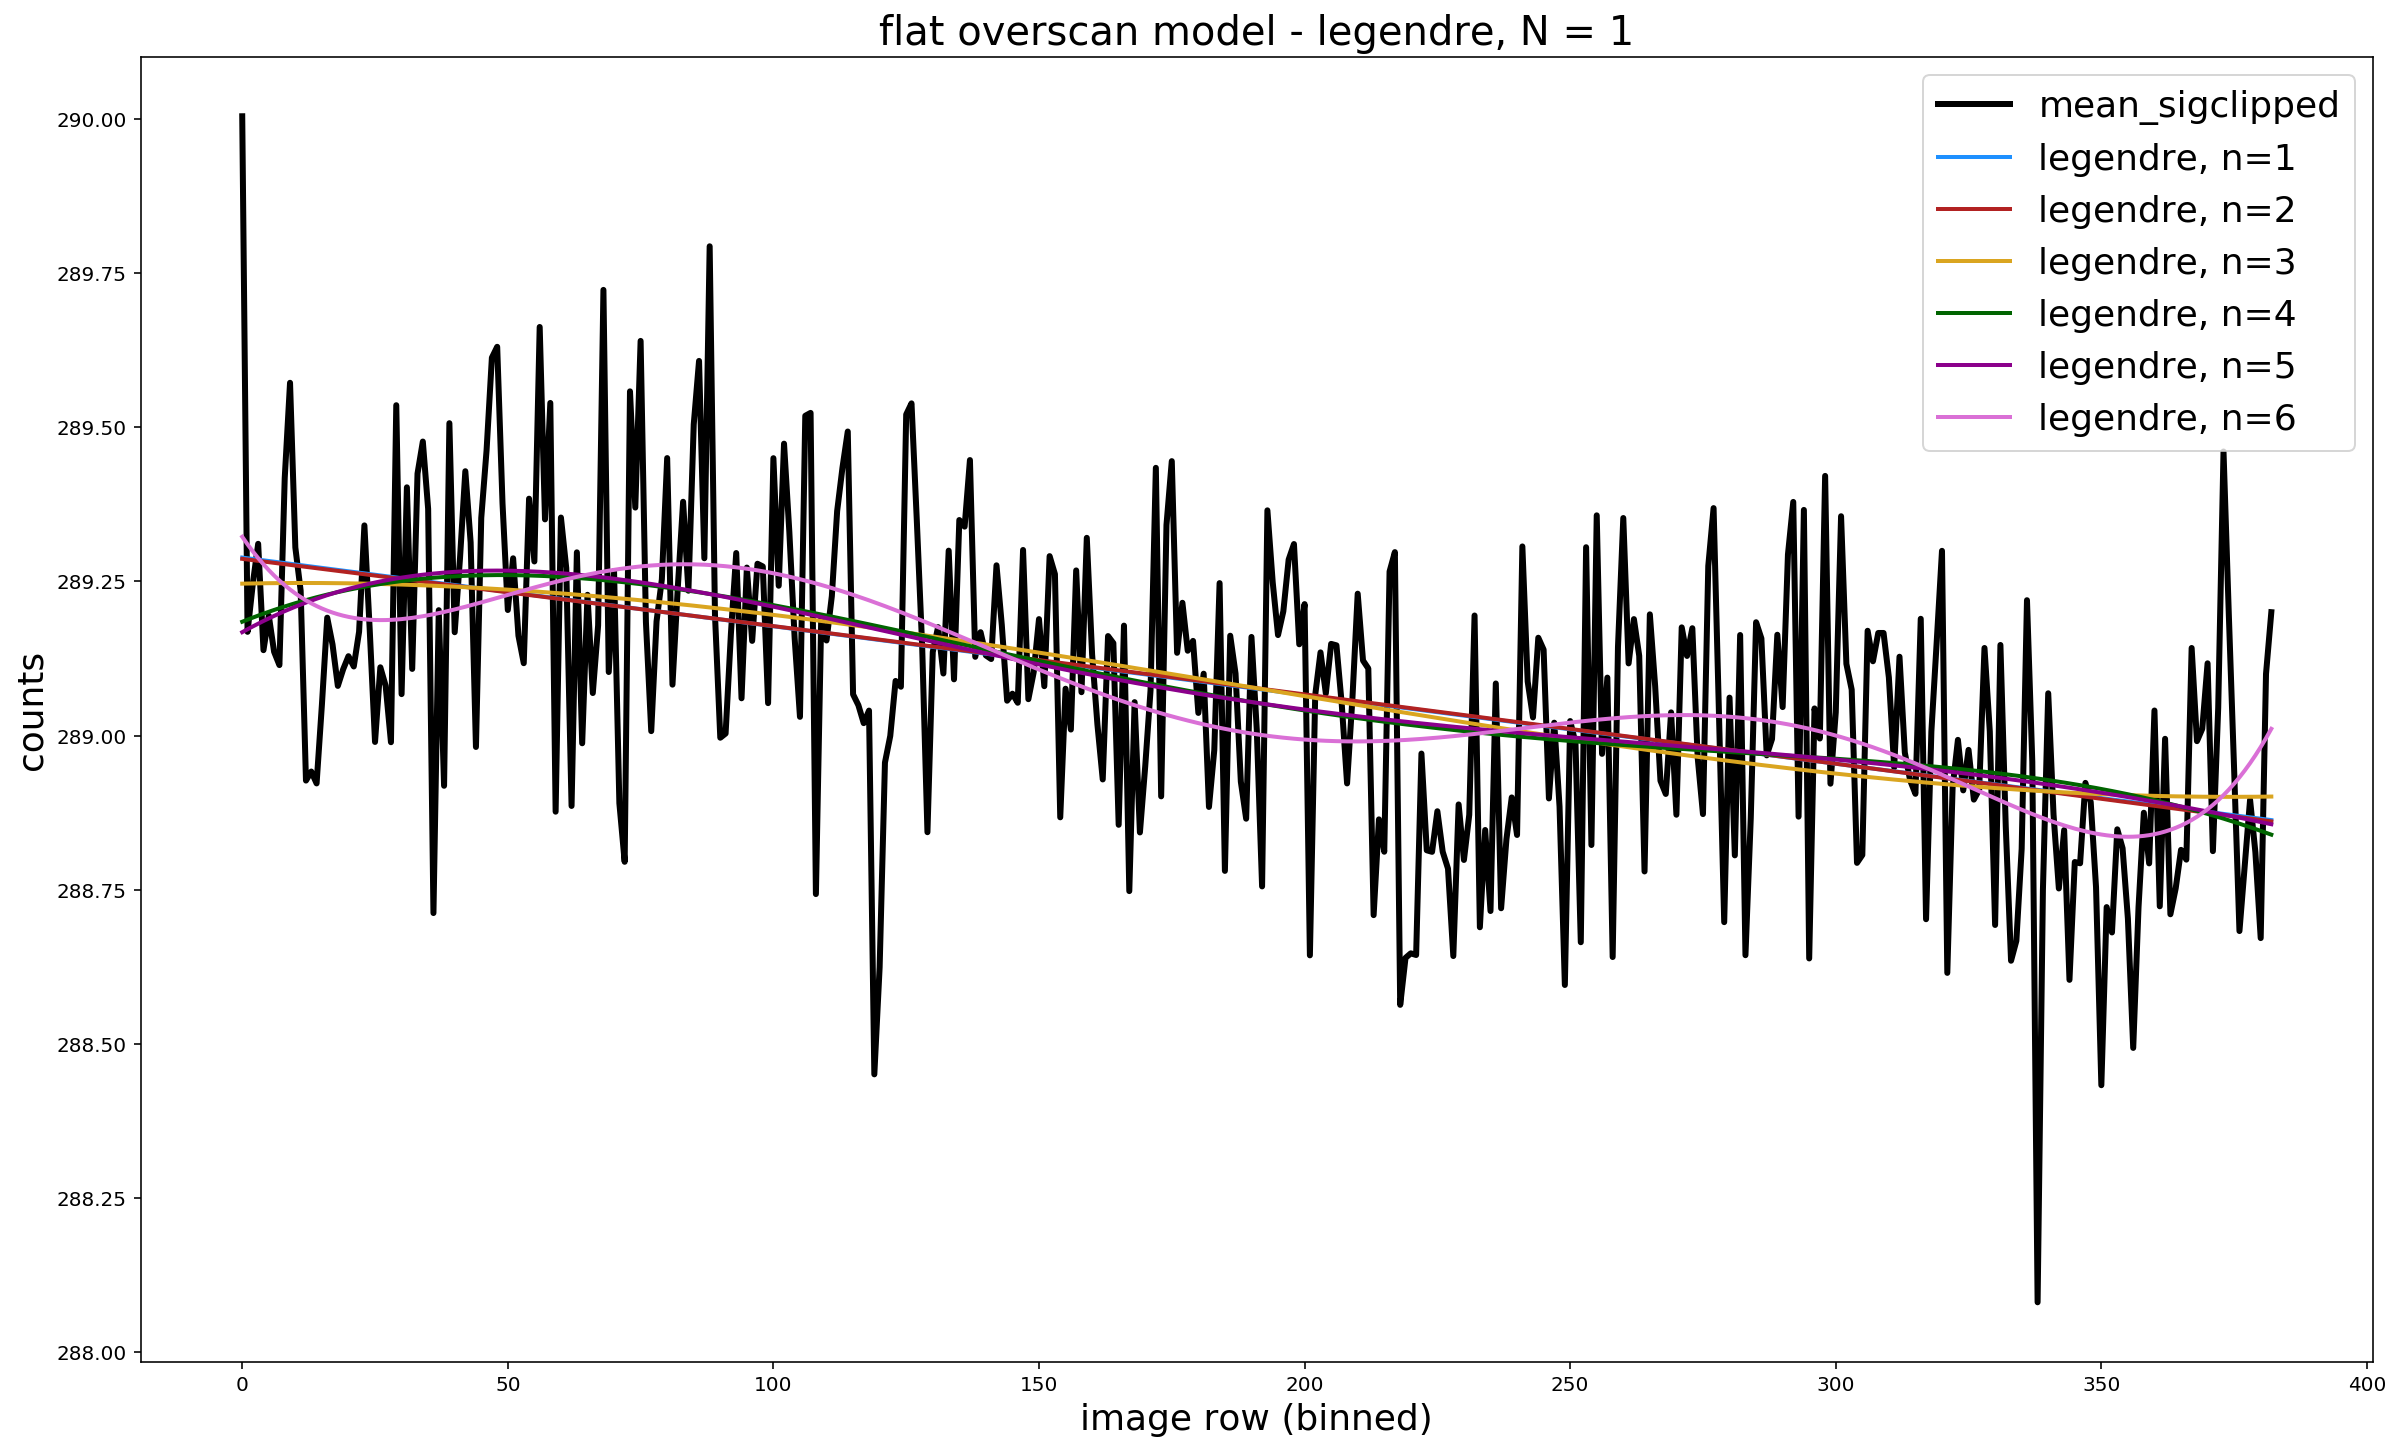

In [258]:
models_flat,fit = plot_overscan(flats,config,imagetyp = 'flat', num_images = 1, flatten_func='sigclip',modeltype='legendre')

<Figure size 432x288 with 0 Axes>

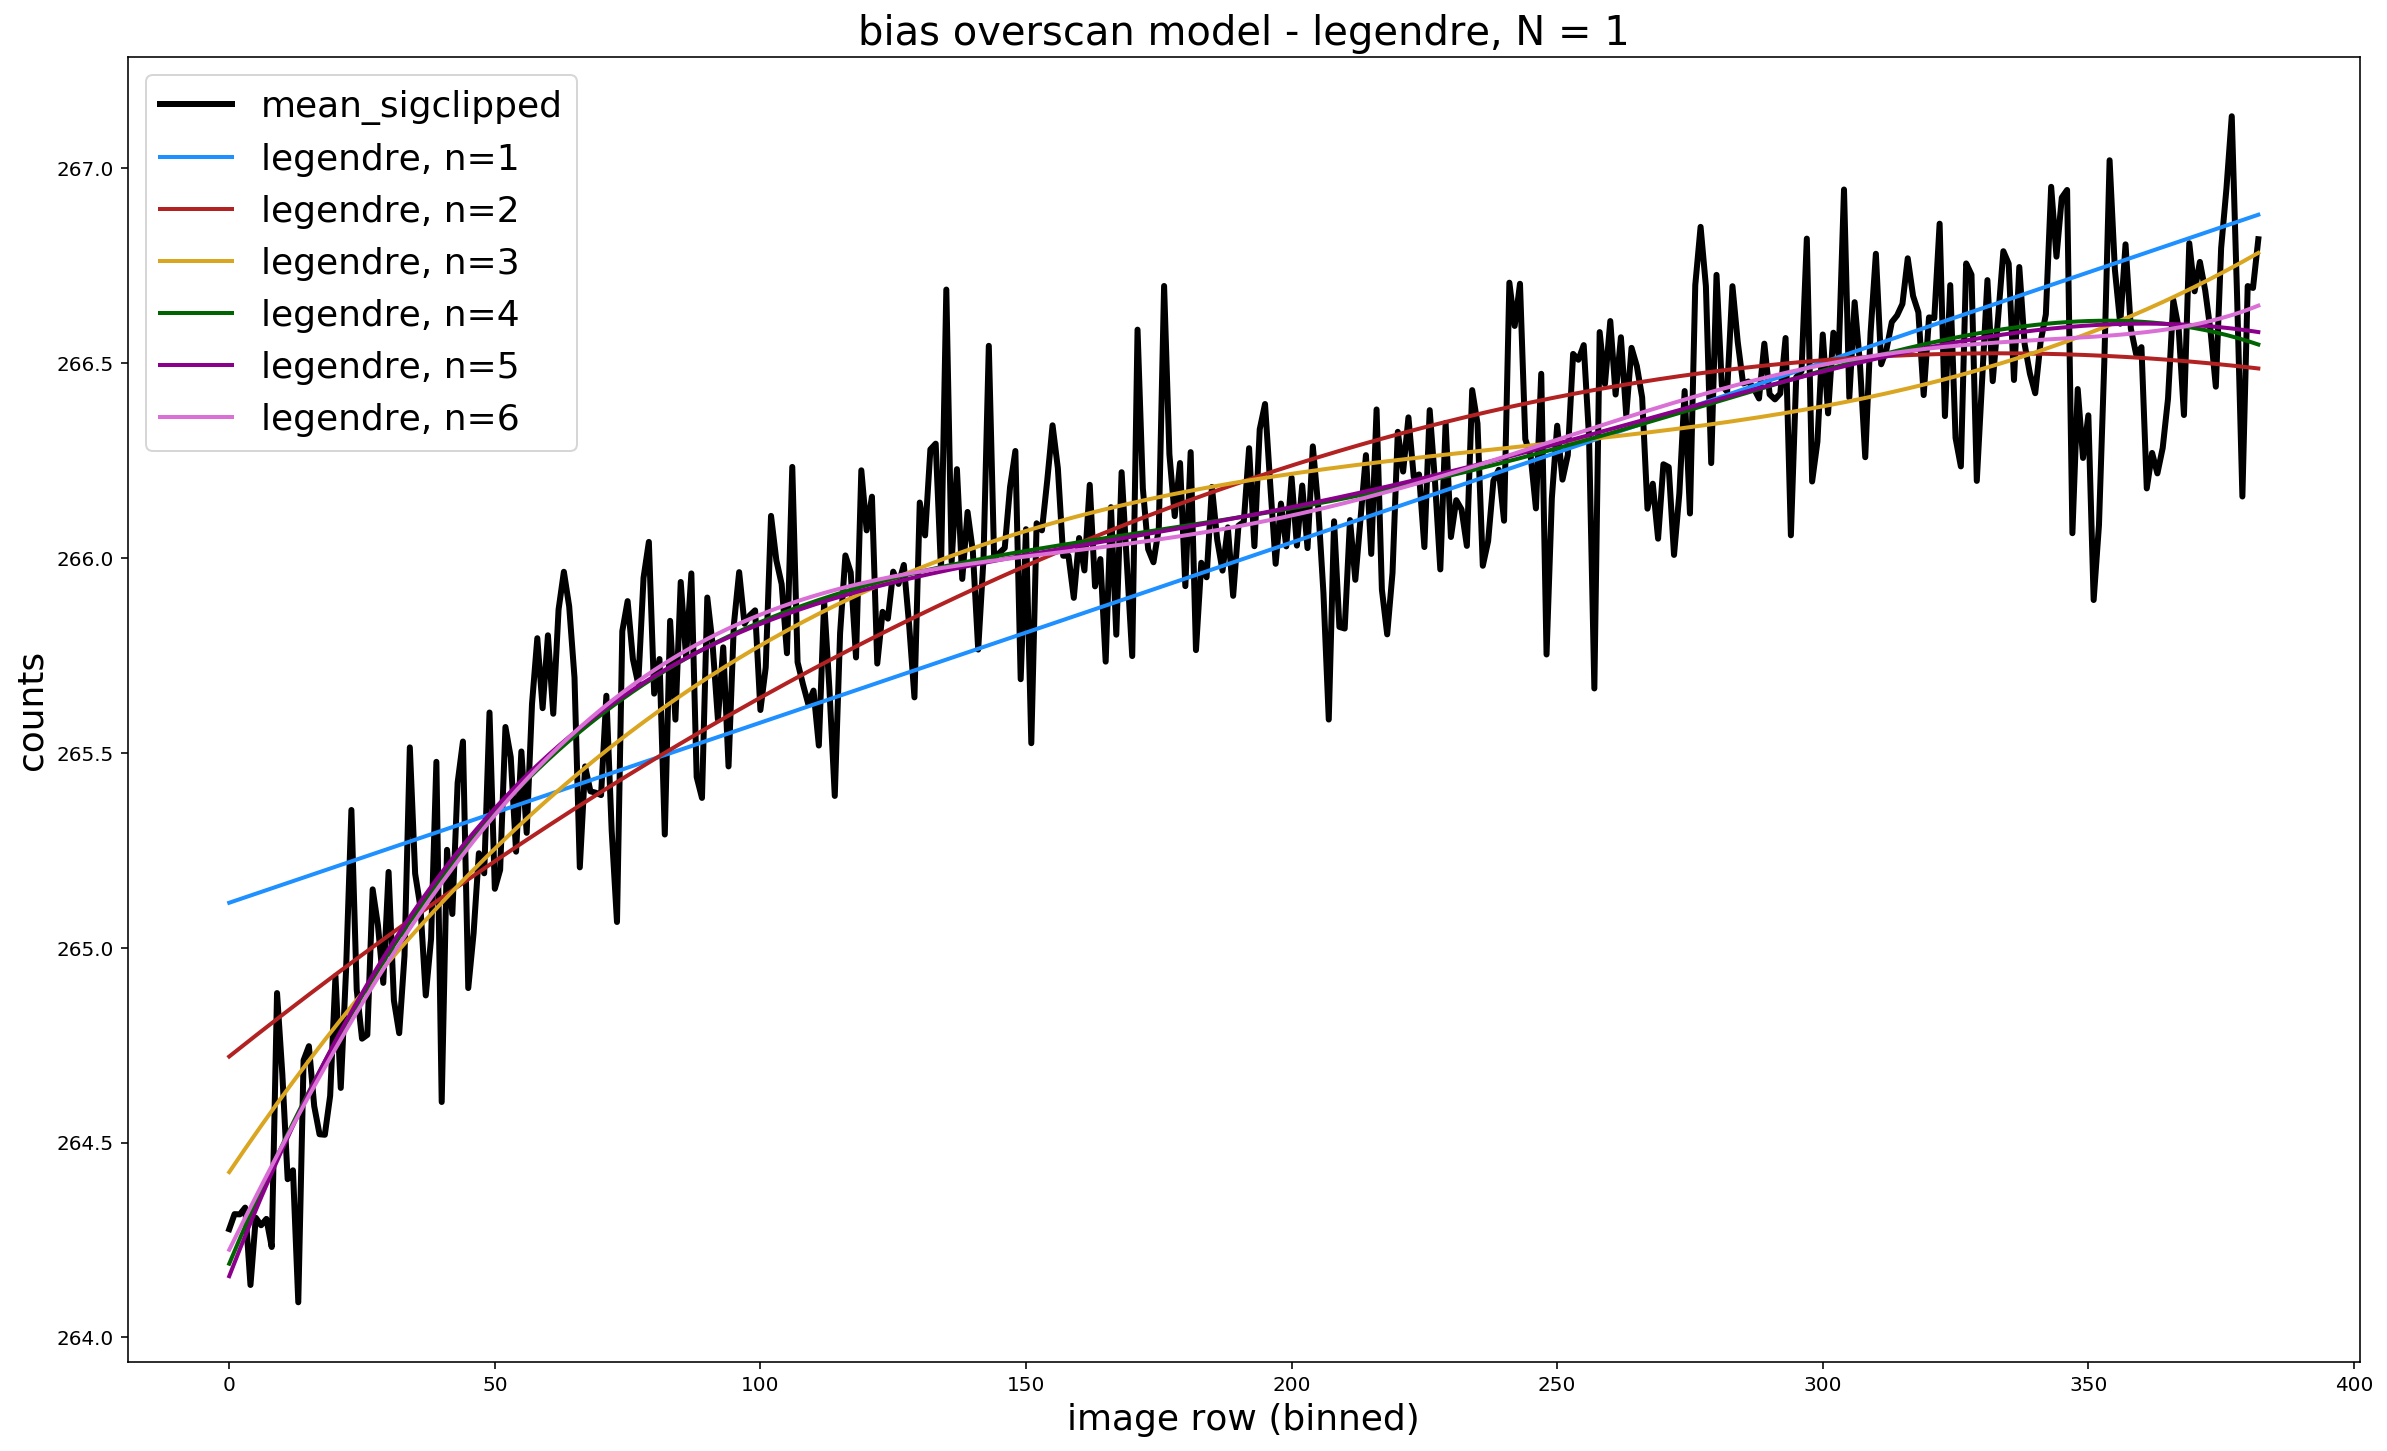

In [275]:
models_bias = plot_overscan(bias,config,imagetyp = 'bias', num_images = 1, flatten_func='sigclip',modeltype='legendre')

<Figure size 432x288 with 0 Axes>

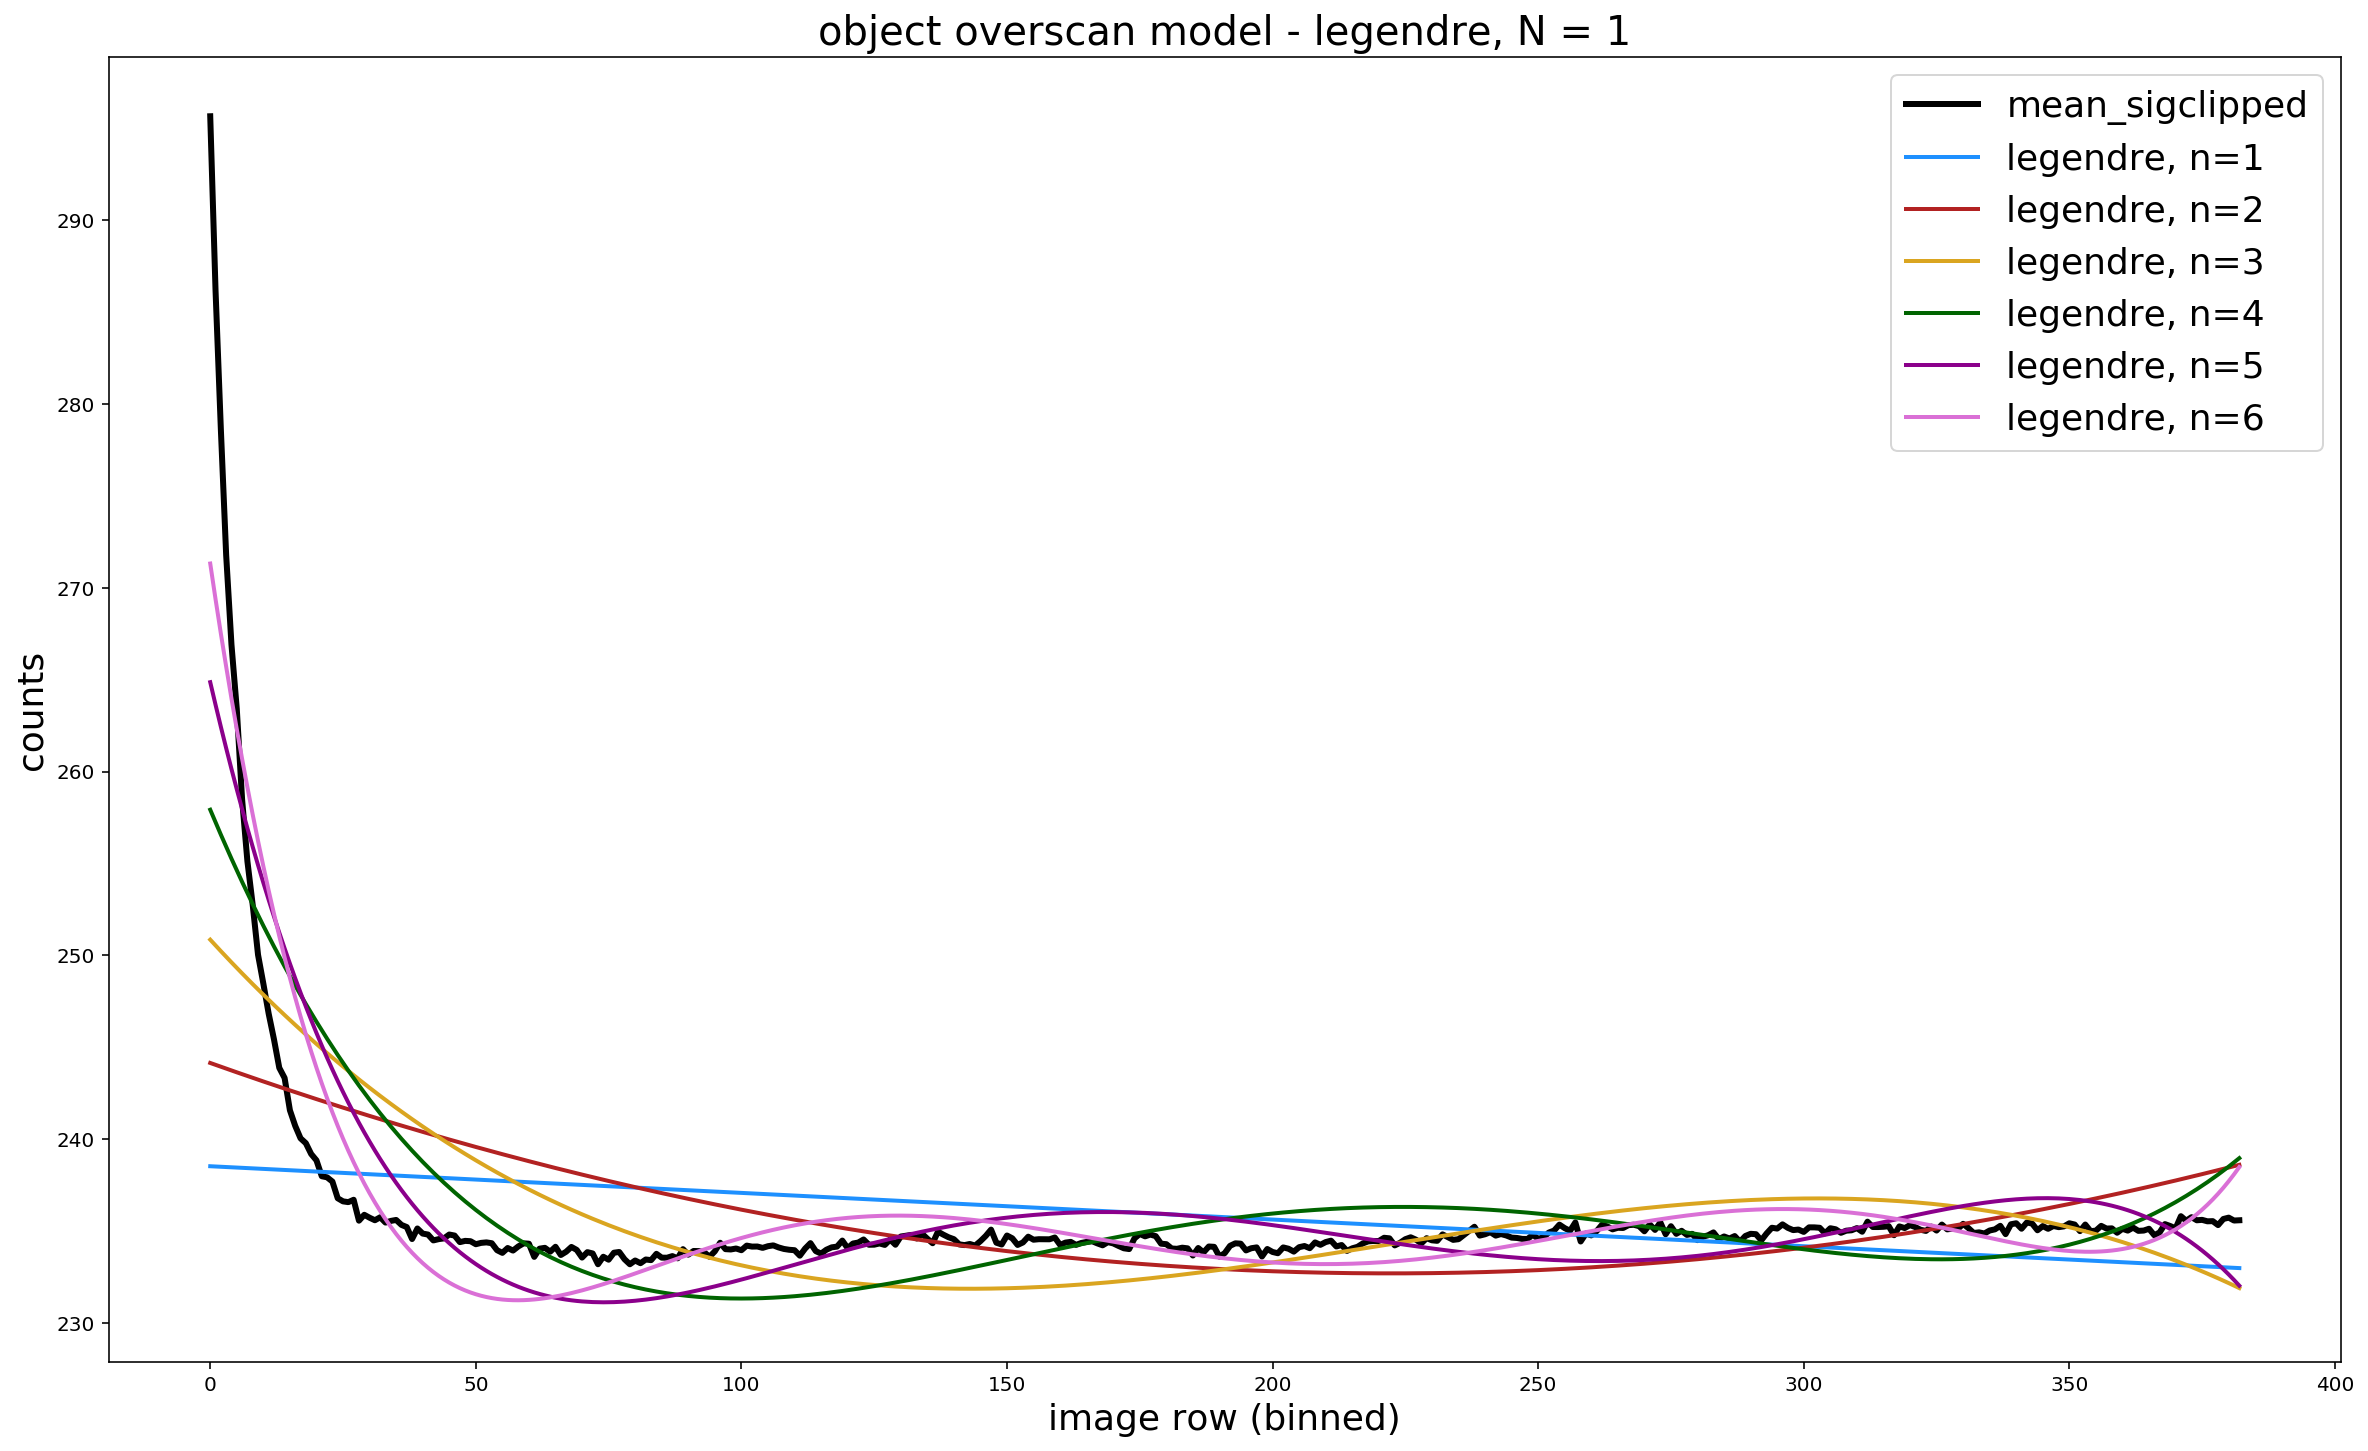

In [273]:
models_obj = plot_overscan(obj,config,imagetyp = 'object', num_images = 1, flatten_func='sigclip',modeltype='legendre')

In [71]:
#Legendre1D(degree, domain=None, window=[-1, 1], n_models=None, model_set_axis=None, name=None, meta=None)

In [97]:
print(models_flat['n1'])

1


In [104]:
fit.fit_info

{'nfev': 11,
 'fvec': array([-0.12599664, -0.6279113 , -1.12981872, ...,  0.07584938,
        -1.92284467,  0.07846762]),
 'fjac': array([[ 2.60042874e+24, -3.84551972e-25, -2.44166468e-22, ...,
         -5.29449838e-02, -5.30140049e-02, -5.30831011e-02],
        [ 3.33503434e+20, -2.78889503e+19,  6.65742408e-18, ...,
         -4.83850640e-02, -4.85752591e-02, -4.87657987e-02],
        [ 4.38683244e+16, -8.07059597e+15, -8.11125257e+14, ...,
          4.35275525e-02,  4.37946412e-02,  4.40624774e-02],
        ...,
        [ 8.65931980e+08, -3.98270729e+08, -1.54392595e+08, ...,
          3.21956460e-02,  3.24933895e-02,  3.27924037e-02],
        [ 1.40954751e+05, -9.26139298e+04, -5.58482977e+04, ...,
         -2.48999699e-02, -2.51525433e-02, -2.54063025e-02],
        [ 3.49628102e+01, -3.21611060e+01, -2.90908132e+01, ...,
          2.33966319e-02,  2.35734775e-02,  2.37511360e-02]]),
 'ipvt': array([7, 6, 5, 4, 3, 2, 1], dtype=int32),
 'qtf': array([ 5.65103520e-12,  6.81898982e-13

In [4]:
bias = image_info[np.where(image_info['imagetyp']=='zero')].copy()
data = CCDData.read(os.path.join(config['out_dir'], 'midproc', bias[0]['filename']), unit=config['data_units'], hdu=config['ext'])
xmin, xmax, ymin, ymax = image.get_ccd_section(data.meta, config['overscan_region'])
data_o = ccdproc.subtract_overscan(data, overscan=data[xmin:xmax,ymin:ymax], median=True, model=models.Legendre1D(degree=2))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


In [6]:
tools.bias('zero',config,bias)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]
CROTAn keyword may not have an alternate version code. [astropy.wcs.wcs]


In [8]:
config

{'image_dir': '/Users/kirstencasey/test_raw_ims',
 'out_dir': '/Users/kirstencasey/test_out',
 'overwrite': True,
 'ext': 1,
 'check_output': True,
 'logger_level': 'INFO',
 'log_to_file': None,
 'notes': '',
 'data_units': 'adu',
 'reduce_selected_chips': {'chip1': False,
  'chip2': True,
  'chip3': False,
  'chip4': False},
 'bias_image_keyword': 'zero',
 'object_image_keyword': 'object',
 'dark_image_keyword': 'dark',
 'flat_image_keyword': 'flat',
 'overscan_region': 'BIASSEC',
 'science_region': 'TRIMSEC',
 'lbc_red': 'LBC-RED',
 'lbc_blue': 'LBC_BLUE',
 'reduce_objects': True,
 'flat': True,
 'overscan': True,
 'stack': True,
 'zero': True,
 'bias': True,
 'dark': False,
 'object': None,
 'propid': None,
 'glob_include': '*.fits',
 'exclude': None,
 'combine_options': {'method': 'average',
  'weights': None,
  'scale': None,
  'mem_limit': 16000000000.0,
  'clip_extrema': True,
  'nlow': 1,
  'nhigh': 1,
  'minmax_clip': False,
  'minmax_clip_min': None,
  'minmax_clip_max': None